# From AutoAI experiment to pipeline refinement with `watson-machine-learning-client`

This notebook contains steps and code to demonstrate support of AutoAI experiments in Watson Machine Learning Service. This notebook introduces commands for getting data, training experiments, persisting pipelines, testing pipelines, refining pipelines, and scoring.

Some familiarity with Python is helpful. This notebook uses Python 3.


## Learning goals

The learning goals of this notebook are:

-  Working with Watson Machine Learning experiments to train AutoAI models.
-  Comparing trained models quality and selecting best one for further refinement.
-  Refining of best model and testing new variations.
-  Online deployment and scoring of trained model.


## Contents

This notebook contains the following parts:

1.	[Setup](#setup)
2.	[Optimizer definition](#definition)
3.	[Experiment Run](#run)
4.	[Pipelines comparison and testing](#comparison)
5.	[Historical runs](#runs)
6.	[Pipeline refinement and testing](#refinery)
7.	[Deploy and Score](#scoring)
8.	[Summary and next steps](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Create a <a href="https://console.ng.bluemix.net/catalog/services/ibm-watson-machine-learning/" target="_blank" rel="noopener no referrer">Watson Machine Learning (WML) Service</a> instance (a free plan is offered and information about how to create the instance can be found <a href="https://dataplatform.ibm.com/docs/content/analyze-data/wml-setup.html" target="_blank" rel="noopener no referrer">here</a>).
-  Create a <a href="https://console.bluemix.net/catalog/infrastructure/cloud-object-storage" target="_blank" rel="noopener no referrer">Cloud Object Storage (COS)</a> instance (a lite plan is offered and information about how to order storage can be found <a href="https://console.bluemix.net/docs/services/cloud-object-storage/basics/order-storage.html#order-storage" target="_blank" rel="noopener no referrer">here</a>). <br/>**Note: When using Watson Studio, you already have a COS instance associated with the project you are running the notebook in.**
- Create new credentials with HMAC: 
    - Go to your COS dashboard.
    - In the **Service credentials** tab, click **New Credential (+)**.
    - Include HMAC credentials (see Advanced options), click **Add**. (For more information, see <a href="https://console.bluemix.net/docs/services/cloud-object-storage/hmac/credentials.html#using-hmac-credentials" target="_blank" rel="noopener no referrer">HMAC</a>.)

### Connections to COS

Enter your COS credentials in the following cell. 

You can find these credentials in your COS instance dashboard under the **Service credentials** tab.

**Note:** The HMAC key described in [set up the environment](#setup) is included in these credentials.

In [1]:
cos_credentials = {

}

In [2]:
# The code was removed by Watson Studio for sharing.

Define the endpoint.

Go to the **Endpoint** tab in the COS instance's dashboard to get the endpoint information, then enter it in the cell below:

In [3]:
cos_credentials['endpoint_url'] = "https://s3.us-south.cloud-object-storage.appdomain.cloud"

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud.

**Tip**: Authentication information (your credentials) can be found in the <a href="https://console.bluemix.net/docs/services/service_credentials.html#service_credentials" target="_blank" rel="noopener no referrer">Service credentials</a> tab of the service instance that you created on IBM Cloud. <BR>If you cannot see the **instance_id** field in **Service Credentials**, click **New credential (+)** to generate new authentication information. 

**Action**: Enter your Watson Machine Learning service instance credentials in the following cell.


In [4]:
wml_credentials = {
    
}

In [5]:
# The code was removed by Watson Studio for sharing.

### Install the `watson-machine-learning-client` package from pypi
**Note:** `watson-machine-learning-client` documentation can be found <a href="http://wml-api-pyclient.mybluemix.net/" target="_blank" rel="noopener no referrer">here</a>.

In [6]:
!pip install -U watson-machine-learning-client-V4 | tail -n 1
!pip install -U autoai-libs | tail -n 1

ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.


In [7]:
!pip show watson-machine-learning-client-V4

Name: watson-machine-learning-client-V4
Version: 1.0.87
Summary: Watson Machine Learning API Client
Home-page: http://wml-api-pyclient-v4.mybluemix.net
Author: IBM
Author-email: svagaral@in.ibm.com, nagiredd@in.ibm.com, amadeusz.masny1@ibm.com
License: BSD
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: ibm-cos-sdk, lomond, tabulate, pandas, scikit-learn, requests, urllib3, certifi
Required-by: 


<a id="definition"></a>
## Optimizer definition

### Training data connection

Define connection information to COS bucket and training data CSV file. This example uses the German Credit Risk dataset. 

The dataset can be downloaded from [here](https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv).

**Action**: Upload training data to COS bucket and enter location information below.

In [8]:
filename = 'german_credit_data_biased_training.csv' # Change to the name of the csv file as you uploaded
bucketname = '<your_bucket_name>'

In [9]:
from watson_machine_learning_client.helpers import DataConnection, S3Connection, S3Location


credit_risk_conn = DataConnection(
    connection=S3Connection(endpoint_url=cos_credentials['endpoint_url'],
                            access_key_id=cos_credentials['cos_hmac_keys']['access_key_id'],
                            secret_access_key=cos_credentials['cos_hmac_keys']['secret_access_key']),
    location=S3Location(bucket=bucketname,
                        path=filename))

training_data_reference=[credit_risk_conn]

### Optimizer configuration

Provide input information for AutoAI optimizer:
- `name` - experiment name
- `prediction_type` - type of the problem
- `prediction_column` - target column name
- `scoring` - optimization metric

In [10]:
from watson_machine_learning_client.experiment import AutoAI

experiment = AutoAI(wml_credentials)

pipeline_optimizer = experiment.optimizer(
    name='Credit Risk Prediction - AutoAI',
    prediction_type=AutoAI.PredictionType.CLASSIFICATION,
    prediction_column='Risk',
    scoring=AutoAI.Metrics.ROC_AUC_SCORE,
)

Configuration parameters can be retrieved via `get_params()`.

In [11]:
pipeline_optimizer.get_params()

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': '',
 'prediction_type': 'classification',
 'prediction_column': 'Risk',
 'scoring': 'roc_auc',
 'test_size': 0.1,
 'max_num_daub_ensembles': 1,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'daub_include_only_estimators': ['ExtraTreesClassifierEstimator',
  'GradientBoostingClassifierEstimator',
  'LGBMClassifierEstimator',
  'LogisticRegressionEstimator',
  'RandomForestClassifierEstimator',
  'XGBClassifierEstimator',
  'DecisionTreeClassifierEstimator'],
 'run_id': None}

<a id="run"></a>
## Experiment run

Call the `fit()` method to trigger the AutoAI experiment. You can either use interactive mode (synchronous job) or background mode (asychronous job) by specifying `background_model=True`.

In [12]:
run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)

Training job d5b2d668-3ffa-4d83-856c-1b629abdf53d completed: 100%|█| 200/200 [03:01<00:00,  1.10it/s]


You can use the `get_run_status()` method to monitor AutoAI jobs in background mode.

In [13]:
pipeline_optimizer.get_run_status()

'completed'

<a id="comparison"></a>
## Pipelines comparison and testing

You can list trained pipelines and evaluation metrics information in
form of a pandas DataFrame by calling the `summary()` method. You can
use the DataFrame to compare all found pipelines and select the one
you like for further testing.

In [14]:
summary = pipeline_optimizer.summary()
summary

,Number of enhancements,training_normalized_gini_coefficient,training_roc_auc_(optimized),holdout_precision,training_average_precision,holdout_average_precision,training_neg_log_loss,holdout_recall,training_precision,holdout_accuracy,training_recall,holdout_f1,holdout_neg_log_loss,holdout_normalized_gini_coefficient,training_accuracy,holdout_roc_auc,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,
Pipeline_4,3,0.426209,0.854311,0.748092,0.782227,0.751530,-0.427627,0.586826,0.774300,0.796,0.580173,0.657718,-0.437965,0.449354,0.803111,0.854309,0.663048
Pipeline_2,1,0.429250,0.852874,0.759690,0.779063,0.761307,-0.431310,0.586826,0.758136,0.800,0.594810,0.662162,-0.428492,0.464890,0.801111,0.860549,0.666390
Pipeline_3,2,0.421347,0.850978,0.785714,0.777890,0.761310,-0.433315,0.592814,0.744888,0.810,0.591484,0.675768,-0.429509,0.485138,0.795778,0.860801,0.659095
Pipeline_1,0,0.424782,0.849756,0.766129,0.777912,0.751348,-0.433591,0.568862,0.766579,0.798,0.586826,0.652921,-0.442632,0.441801,0.802000,0.848807,0.664322


You can visualize scoring metric calculated on holdout data set.

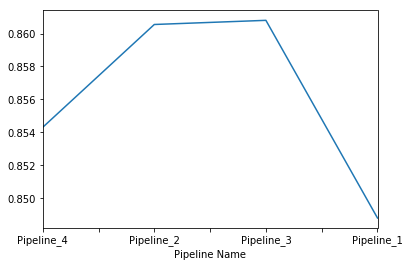

In [15]:
%matplotlib inline

summary.holdout_roc_auc.plot();

### Get selected pipeline model

Download and reconstruct a scikit-learn pipeline model object from the
AutoAI training job.

In [16]:
best_pipeline = pipeline_optimizer.get_pipeline()

### Convert the pipeline model to a Python script and download it

In [17]:
from watson_machine_learning_client.helpers import pipeline_to_script
pipeline_to_script(best_pipeline)

### Visualize pipeline

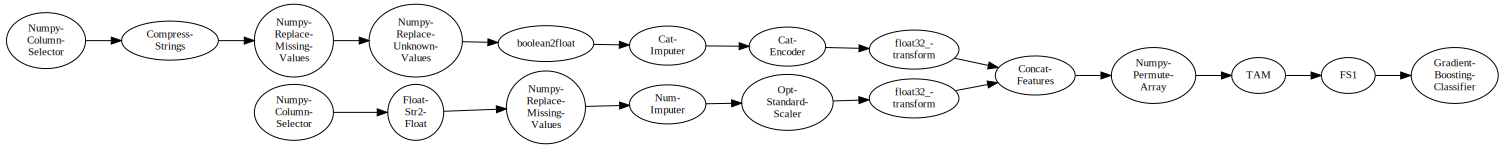

In [18]:
best_pipeline.visualize()

Each node in the visualization is a machine-learning operator
(transformer or estimator). Each edge indicates data flow (transformed
output from one operator becomes input to the next).  The input to the
root nodes is the initial dataset and the output from the sink node
is the final prediction.  When you hover the mouse pointer over a
node, a tooltip shows you the configuration arguments of the
corresponding operator (tuned hyperparameters). When you click on the
hyperlink of a node, it brings you to a documentation page for the
operator.

### Pipeline source code

In [19]:
best_pipeline.pretty_print(ipython_display=True)

```python
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.lale import ConcatFeatures
from lale.lib.autoai_libs import NumpyPermuteArray
from lale.lib.autoai_libs import TAM
import autoai_libs.cognito.transforms.transform_extras
from lale.lib.autoai_libs import FS1
from lale.lib.sklearn import GradientBoostingClassifier
import lale
lale.wrap_imported_operators()

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'char_str', 'char_str', 'char_str', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str', 'int_num', 'char_str', 'int_num', 'char_str', 'char_str'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan'), float('nan')], known_values_list=[[227259264688753646810077375790908286508, 253732214910815238134509288111402486722, 303819144345098626554456011496217223575, 280353606872939388614315901186094326949], [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 59, 60, 61, 62, 63, 64], [310861434292724266828512742170106879235, 259078546728323006823621149382123274851, 241304191515355600141369672905481462228, 210421363963937264134596964576525922958, 32212939341074532066845731816970003693], [338473629843581165720544432281125239609, 326781793206258442673692969623843435113, 272002530391893084684429324616350007975, 249661578098852569030863268336475104259, 277452992311061223498548004061740954923, 337000624133206789825115182809991844205, 161330870025401753341235738137984802479, 133401727367742042681318083577551821203, 260491112873202394519945523636494874646, 208131593747174447223154626949015695834, 317093190772141179412539616679296858597], [155466114539413991851582417126364895339, 246789352403109329930648176329125946981, 295936621451169689699218469248254275361, 223681476361652455808150317408145666122, 230715114430321724850934713783197932106], [185340558928138909626603812763488190588, 319328661378046583715176476627492385778, 263799749086692576083148855705354099872, 179222502770383138876302755836424893586, 283364312271660996400883763491949419861], [1, 2, 3, 4, 5, 6], [52149379001264932068757487059177351405, 10381015089147753033583386570985939629], [90380513159839424205657141466603309780, 72020144360318906788270974425375628494, 68186749286663113704472210246844540664], [1, 2, 3, 4, 5, 6], [184210183797580735197442541762508088723, 112784645159752486323086095897586579102, 194064631024616485005022213750224679171, 230715114430321724850934713783197932106], [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 73, 74], [251696305476606261219998849299484831626, 68186749286663113704472210246844540664, 129843969358953857049997737920307864573], [226204649993248704235747196731638161812, 240703879997496844699455009880498205665, 243184888600665221836895697954701357177], [1, 2, 3, 4], [328286527295663582663365503319902632676, 119641707607939038914465000864290288880, 283364312271660996400883763491949419861, 27741019508977055807423991753468819528], [1, 2], [68186749286663113704472210246844540664, 220736790854050750400968561922076059550], [169662019754859674907370307324476606919, 220736790854050750400968561922076059550]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
numpy_column_selector_1 = NumpyColumnSelector(columns=[4])
float_str2_float = FloatStr2Float(dtypes_list=['int_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 4])
tam = TAM(tans_class=autoai_libs.cognito.transforms.transform_extras.IsolationForestAnomaly, name='isoforestanomaly', col_names=['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker'], col_dtypes=[np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32'), np.dtype('float32')])
fs1 = FS1(cols_ids_must_keep=range(0, 20), additional_col_count_to_keep=20)
gradient_boosting_classifier = GradientBoostingClassifier(max_depth=5, max_features=0.010000001389660496, min_samples_leaf=0.010000000118211241, min_samples_split=0.010000026400127577, n_estimators=78, random_state=33)
pipeline = ((numpy_column_selector_0 >> compress_strings >> numpy_replace_missing_values_0 >> numpy_replace_unknown_values >> boolean2float() >> cat_imputer >> cat_encoder >> float32_transform()) & (numpy_column_selector_1 >> float_str2_float >> numpy_replace_missing_values_1 >> num_imputer >> opt_standard_scaler >> float32_transform())) >> ConcatFeatures() >> numpy_permute_array >> tam >> fs1 >> gradient_boosting_classifier
```

In the pretty-printed code, `>>` is the pipe combinator (dataflow
edge) and `&` is the and combinator (combining multiple subpipelines).
They correspond to the `make_pipeline` and `make_union` functions from
scikit-learn, respectively. If you prefer the functions, you can
instead pretty-print your pipeline with
`best_pipeline.pretty_print(ipython_display=True, combinators=False)`.

### Reading training and holdout data from COS

In [20]:
training_df, holdout_df = pipeline_optimizer.get_data_connections()[0].read(with_holdout_split=True)

holdout_X = holdout_df.drop(['Risk'], axis=1).values
holdout_y = holdout_df.Risk.values

### Test pipeline model locally

In [21]:
from sklearn.metrics import roc_auc_score

predicted_y = best_pipeline.predict(holdout_X)
score = roc_auc_score(predicted_y=='Risk', holdout_y=='Risk')
print(f'roc_auc_score {score:.1%}')

roc_auc_score 82.3%


<a id="runs"></a>
## Historical runs

In this section you will learn how to work with historical AutoPipelines fit jobs (runs).

To list historical runs use method `list()`. You can filter runs by providing experiment name.

In [22]:
experiment.runs(filter='Credit Risk Prediction - AutoAI').list()

,timestamp,run_id,state,auto_pipeline_optimizer name
6,2020-05-11T17:44:03.595Z,d5b2d668-3ffa-4d83-856c-1b629abdf53d,completed,Credit Risk Prediction - AutoAI
3,2020-05-11T17:37:30.327Z,9d936972-84c5-4731-8340-402ccd7035ff,completed,Credit Risk Prediction - AutoAI
5,2020-05-11T16:43:44.771Z,d13815d1-74be-42b6-ab1e-56ddaaceb624,failed,Credit Risk Prediction - AutoAI
8,2020-05-04T21:39:54.181Z,e3b49cfb-228d-44e4-9aea-e0121ddc0c72,completed,Credit Risk Prediction - AutoAI
7,2020-05-01T04:12:32.596Z,dd724152-b6de-42f8-b866-bff30720f7e1,failed,Credit Risk Prediction - AutoAI
1,2020-04-30T04:51:33.461Z,52899ff4-5014-479c-9f23-708d8efdf610,failed,Credit Risk Prediction - AutoAI
4,2020-04-30T04:48:12.898Z,a3e98fa9-d285-4673-b008-e597de3c31cc,failed,Credit Risk Prediction - AutoAI
9,2020-04-30T04:36:46.221Z,e46b9b17-53bd-4606-b02e-79fd6719893e,failed,Credit Risk Prediction - AutoAI
0,2020-04-30T04:36:11.446Z,445c4097-a4c4-40ba-a38b-c95e43a4dc6a,failed,Credit Risk Prediction - AutoAI
2,2020-04-30T04:32:40.667Z,75a5b7ef-6a9d-4ccd-9a5a-08886020ff9f,failed,Credit Risk Prediction - AutoAI


To work with historical pipelines found during a particular optimizer
run, you need to first provide the `run_id` to select the fitted
optimizer.

**ACTION:** assign selected run_id to `run_id` variable.

In [23]:
run_id = '' # Enter the run_id of the runs that you would like to deploy and analyze

### Get executed optimizer's configuration parameters

In [24]:
experiment.runs.get_params(run_id=run_id)

{'name': 'Credit Risk Prediction - AutoAI',
 'desc': '',
 'prediction_type': 'classification',
 'prediction_column': 'Risk',
 'scoring': 'roc_auc',
 'test_size': 0.1,
 'max_num_daub_ensembles': 1,
 't_shirt_size': 'm',
 'train_sample_rows_test_size': None,
 'daub_include_only_estimators': ['ExtraTreesClassifierEstimator',
  'GradientBoostingClassifierEstimator',
  'LGBMClassifierEstimator',
  'LogisticRegressionEstimator',
  'RandomForestClassifierEstimator',
  'XGBClassifierEstimator',
  'DecisionTreeClassifierEstimator']}


### Get historical optimizer instance and training details

In [25]:
historical_opt = experiment.runs.get_optimizer(run_id)

In [26]:
run_details = historical_opt.get_run_details()

### List trained pipelines for selected optimizer

In [27]:
historical_opt.summary()

,Number of enhancements,training_normalized_gini_coefficient,training_roc_auc_(optimized),holdout_precision,training_average_precision,holdout_average_precision,training_neg_log_loss,holdout_recall,training_precision,holdout_accuracy,training_recall,holdout_f1,holdout_neg_log_loss,holdout_normalized_gini_coefficient,training_accuracy,holdout_roc_auc,training_f1
Pipeline Name,,,,,,,,,,,,,,,,,
Pipeline_4,3,0.426209,0.854311,0.748092,0.782227,0.751530,-0.427627,0.586826,0.774300,0.796,0.580173,0.657718,-0.437965,0.449354,0.803111,0.854309,0.663048
Pipeline_2,1,0.429250,0.852874,0.759690,0.779063,0.761307,-0.431310,0.586826,0.758136,0.800,0.594810,0.662162,-0.428492,0.464890,0.801111,0.860549,0.666390
Pipeline_3,2,0.421347,0.850978,0.785714,0.777890,0.761310,-0.433315,0.592814,0.744888,0.810,0.591484,0.675768,-0.429509,0.485138,0.795778,0.860801,0.659095
Pipeline_1,0,0.424782,0.849756,0.766129,0.777912,0.751348,-0.433591,0.568862,0.766579,0.798,0.586826,0.652921,-0.442632,0.441801,0.802000,0.848807,0.664322


### Get selected pipeline and test locally

In [28]:
hist_pipeline = historical_opt.get_pipeline(pipeline_name='Pipeline_3')

In [29]:
predicted_y = hist_pipeline.predict(holdout_X)
score = roc_auc_score(predicted_y=='Risk', holdout_y=='Risk')
print(f'roc_auc_score {score:.1%}')

roc_auc_score 81.1%


---

<a id="refinery"></a>
## Pipeline refinement with [Lale](https://github.com/IBM/lale) and testing

In this section you will learn how to refine and retrain the best
pipeline returned by AutoAI. There are many ways to refine a pipeline.
For illustration, here we simply replace the final estimator in the
pipeline by an interpretable model. The call to
`wrap_imported_operators()` augments scikit-learn operators with
schemas for hyperparameter tuning.

In [30]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from lale.lib.lale import Hyperopt
from lale import wrap_imported_operators

wrap_imported_operators()

### Pipeline decomposition and new definition

We start by removing the last step of the pipeline, i.e., the final estimator.

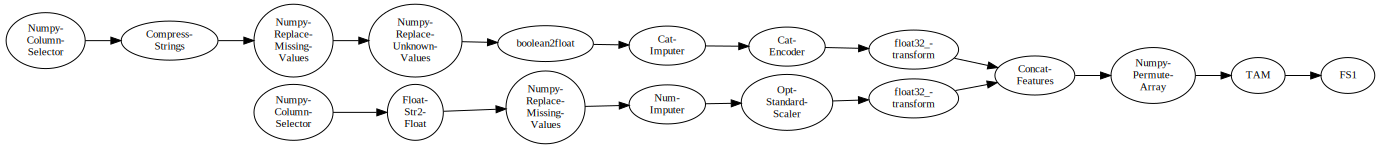

In [31]:
prefix = hist_pipeline.remove_last().freeze_trainable()
prefix.visualize()

Next, we add a new final step, consisting of a choice of three
estimators. In this code, `|` is the or combinator (algorithmic
choice). It defines a search space for another optimizer run.

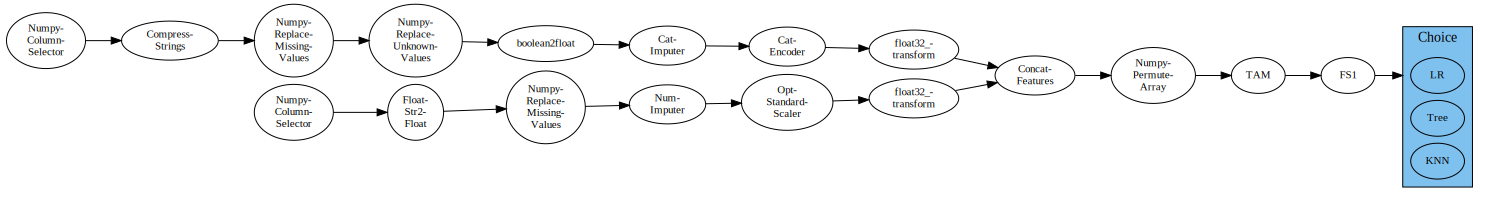

In [32]:
new_pipeline = prefix >> (LR | Tree | KNN)
new_pipeline.visualize()

### New optimizer `Hyperopt` configuration and training

To automatically select the algorithm and tune its hyperparameters, we
create an instance of the `Hyperopt` optimizer and `fit` it to the
data.

In [33]:
train_X = training_df.drop(['Risk'], axis=1).values
train_y = training_df['Risk'].values

hyperopt = Hyperopt(estimator=new_pipeline, cv=3, max_evals=20, scoring='roc_auc')
hyperopt_pipelines = hyperopt.fit(train_X, train_y)

100%|██████████| 20/20 [10:45<00:00, 68.19s/trial, best loss: -0.8399317481153808]


In [34]:
pipeline_model = hyperopt_pipelines.get_pipeline()

### Pipeline model tests and visualization

In [35]:
predicted_y = pipeline_model.predict(holdout_X)
score = roc_auc_score(predicted_y=='Risk', holdout_y=='Risk')
print(f'roc_auc_score {score:.1%}')

roc_auc_score 75.5%


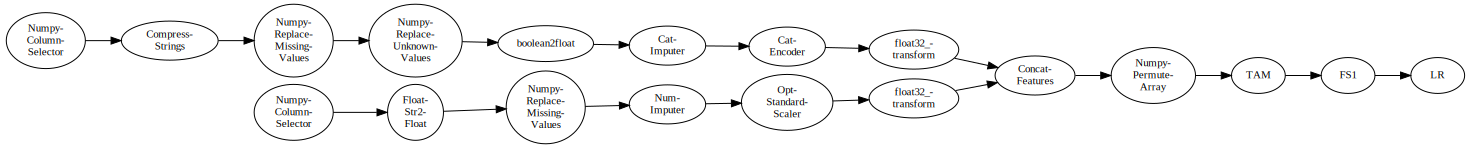

In [36]:
pipeline_model.visualize()

<a id="scoring"></a>
## Deploy and Score

In this section you will learn how to deploy and score pipeline model as webservice using WML instance.

### Deployment creation

In [37]:
from watson_machine_learning_client.deployment import WebService

service = WebService(wml_credentials)

service.create(
    experiment_run_id=run_id,
    model=pipeline_model, 
    deployment_name="Credit Risk Deployment AutoAI")

Preparing an AutoAI Deployment...
Published model uid: cab3383d-2a07-47c5-9ea1-f15f18278269
Deploying model cab3383d-2a07-47c5-9ea1-f15f18278269 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: 'cab3383d-2a07-47c5-9ea1-f15f18278269' started

#######################################################################################


initializing.......
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='ef68fa8e-ab91-44cd-9812-f5909a9f09ed'
------------------------------------------------------------------------------------------------




Deployment object could be printed to show basic information:

In [38]:
print(service)

name: Credit Risk Deployment AutoAI, id: ef68fa8e-ab91-44cd-9812-f5909a9f09ed, scoring_url: https://us-south.ml.cloud.ibm.com/v4/deployments/ef68fa8e-ab91-44cd-9812-f5909a9f09ed/predictions, asset_id: cab3383d-2a07-47c5-9ea1-f15f18278269


To be able to show all available information about deployment use `.get_params()` method:

In [39]:
service.get_params()

{'metadata': {'parent': {'href': ''},
  'name': 'Credit Risk Deployment AutoAI',
  'guid': 'ef68fa8e-ab91-44cd-9812-f5909a9f09ed',
  'description': '',
  'id': 'ef68fa8e-ab91-44cd-9812-f5909a9f09ed',
  'modified_at': '2020-05-11T18:02:48.711Z',
  'created_at': '2020-05-11T18:02:06.823Z',
  'href': '/v4/deployments/ef68fa8e-ab91-44cd-9812-f5909a9f09ed'},
 'entity': {'name': 'Credit Risk Deployment AutoAI',
  'custom': {},
  'online': {},
  'description': '',
  'status': {'state': 'ready',
   'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/v4/deployments/ef68fa8e-ab91-44cd-9812-f5909a9f09ed/predictions'}},
  'asset': {'href': '/v4/models/cab3383d-2a07-47c5-9ea1-f15f18278269?rev=5d4fd904-d4c5-4da7-9a7a-b94865dde16e'}}}

### Scoring of webservice
You can make scoring request by calling `score()` on deployed pipeline.

In [40]:
predictions = service.score(payload=holdout_df.drop(['Risk'], axis=1).iloc[:10])
predictions

{'predictions': [{'fields': ['prediction', 'probability'],
   'values': [['No Risk', [0.5324916361054957, 0.46750836389450434]],
    ['No Risk', [0.6435802747447263, 0.35641972525527366]],
    ['No Risk', [0.9620729831409408, 0.03792701685905922]],
    ['No Risk', [0.9482653360387235, 0.05173466396127645]],
    ['No Risk', [0.8680608138152848, 0.1319391861847152]],
    ['Risk', [0.04832542739789725, 0.9516745726021028]],
    ['No Risk', [0.5865132110384217, 0.41348678896157826]],
    ['No Risk', [0.909256829906103, 0.09074317009389703]],
    ['Risk', [0.4983847890602747, 0.5016152109397253]],
    ['No Risk', [0.5699163868908697, 0.4300836131091304]]]}]}

If you want to work with the webservice in external Python application you can retrieve the service object by:
 - initialize service by `service = WebService(wml_credentials)`
 - get deployment_id by `service.list()` method
 - get webservice object by `service.get('deployment_id')` method

After that you can call `service.score()` method.

### Deleting deployment
You can delete exeiting deployment by calling `service.delete()` command.
To list existing web services you can use `service.list()`.

In [41]:
service.list()

,created_at,modified_at,id,name,status
1,2020-05-11T18:02:06.823Z,2020-05-11T18:02:53.680Z,ef68fa8e-ab91-44cd-9812-f5909a9f09ed,Credit Risk Deployment AutoAI,ready
0,2020-05-04T22:39:39.128Z,2020-05-11T18:02:53.669Z,c2c727df-4f41-470c-969b-2def601b89a3,Credit Risk Deployment AutoAI,ready
3,2020-04-30T04:03:33.914Z,2020-04-30T04:03:34.168Z,50986efe-931a-4358-b8f0-78eb8ad320df,Predict Boston house prices with XGBRegressor,ready
2,2020-04-30T03:27:42.301Z,2020-04-30T03:27:42.908Z,1101d141-f217-4967-a18d-c16a99f4f7c5,Predict breast cancer,ready


<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!.
 
 You learned how to use `watson-machine-learning-client` to run AutoAI experiments. 
 
 Check out our _[Online Documentation](https://www.ibm.com/cloud/watson-studio/autoai)_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors

**Lukasz Cmielowski**, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

**Amadeusz Masny**, Python Software Developer in Watson Machine Learning at IBM

**Kiran Kate**, Senior Software Engineer at IBM Research AI

**Martin Hirzel**, Research Staff Member and Manager at IBM Research AI

Copyright © 2020 IBM. This notebook and its source code are released under the terms of the MIT License.